In [1]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import Image

ROOT.gROOT.LoadMacro("../atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("../atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("../atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()

ROOT.EnableImplicitMT()
# ROOT.gROOT.SetBatch(True)

delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")

save_folder = "non_dark_plots"


if status == 0:
    print("libDelphes.so loaded successfully!")
else:
    print("Error: Could not load libDelphes.so")
    exit()


Applying ATLAS style settings...

libDelphes.so loaded successfully!


In [2]:
fdir = delphes_dir + "displacedPhoton/non_dark_events.root"

# Create the RDataFrame
df = ROOT.RDataFrame("Delphes", fdir)

# Filter out events that have no photons to prevent errors
df_photons = df.Filter("Photon_size > 1", "Events with at least one photon")

# First, define the index for the highest pT photon
df_with_max_idx = df_photons.Define("sorted_indices", "ROOT::VecOps::Argsort(Photon.PT)") \
                            .Define("idx_max_pt", "sorted_indices.back()") \
                            .Define("idx_second_max_pt", "sorted_indices[sorted_indices.size() - 2]")

# Use the index to get the Eta and Phi of that specific photon
df_final = df_with_max_idx.Define("pt_max_pt", "Photon.PT[idx_max_pt]") \
                          .Define("eta_max_pt", "Photon.Eta[idx_max_pt]") \
                          .Define("phi_max_pt", "Photon.Phi[idx_max_pt]") \
                          .Define("pt_second_max_pt", "Photon.PT[idx_second_max_pt]") \
                          .Define("eta_second_max_pt", "Photon.Eta[idx_second_max_pt]") \
                          .Define("phi_second_max_pt", "Photon.Phi[idx_second_max_pt]")
                          
# Define 4-vectors for the two highest pT photons
df_final = df_final.Define("vec1", "ROOT::Math::PtEtaPhiMVector(Photon.PT[idx_max_pt], Photon.Eta[idx_max_pt], Photon.Phi[idx_max_pt], 0.0)") \
                   .Define("vec2", "ROOT::Math::PtEtaPhiMVector(Photon.PT[idx_second_max_pt], Photon.Eta[idx_second_max_pt], Photon.Phi[idx_second_max_pt], 0.0)")

# Combine the two 4-vectors and calculate the invariant mass
df_final = df_final.Define("combined_vec", "vec1 + vec2") \
                   .Define("mass_combined", "combined_vec.M()") \
                   .Define("phi_combined", "combined_vec.Phi()") \
                   .Define("eta_combined", "combined_vec.Eta()")

In [ ]:
# Convert to numpy dict
particle_dict = df.AsNumpy([
    "Event.Number",
    "Particle.PT",
    "Particle.Eta",
    "Particle.Phi",
    "Particle.Mass",
    "Particle.PID",
    "Particle.fUniqueID",
    "Particle.M1",
    "Particle.M2",
    "Particle.D1",
    "Particle.D2",
    "Particle.P",
    "Particle.Status",
    "Particle.Charge",
    "Particle.T"
])

# Flatten Event.Number to scalars (each event has 1 number, so take [0])
event_numbers = [arr[0] for arr in particle_dict["Event.Number"]]

# Build DataFrame
particle_df = pd.DataFrame({
    "EventNumber": event_numbers,
    "Particle.PT": particle_dict["Particle.PT"],
    "Particle.Eta": particle_dict["Particle.Eta"],
    "Particle.Phi": particle_dict["Particle.Phi"],
    "Particle.Mass": particle_dict["Particle.Mass"],
    "Particle.PID": particle_dict["Particle.PID"],
    "Particle.fUniqueID": particle_dict["Particle.fUniqueID"],
    "Particle.M1": particle_dict["Particle.M1"],
    "Particle.M2": particle_dict["Particle.M2"],
    "Particle.D1": particle_dict["Particle.D1"],
    "Particle.D2": particle_dict["Particle.D2"],
    "Particle.P": particle_dict["Particle.P"],
    "Particle.Status": particle_dict["Particle.Status"],
    "Particle.Charge": particle_dict["Particle.Charge"],
    "Particle.T": particle_dict["Particle.T"],
})

# Filter events first (on scalar event numbers)
particle_df = particle_df[particle_df["EventNumber"] < 10]

# Now explode so each particle is a row
particle_df = particle_df.explode([
    "Particle.PT",
    "Particle.Eta",
    "Particle.Phi",
    "Particle.Mass",
    "Particle.PID",
    "Particle.fUniqueID",
    "Particle.M1",
    "Particle.M2",
    "Particle.D1",
    "Particle.D2",
    "Particle.P",
    "Particle.Status",
    "Particle.Charge",
    "Particle.T"
], ignore_index=True)

particle_df.head()


: 

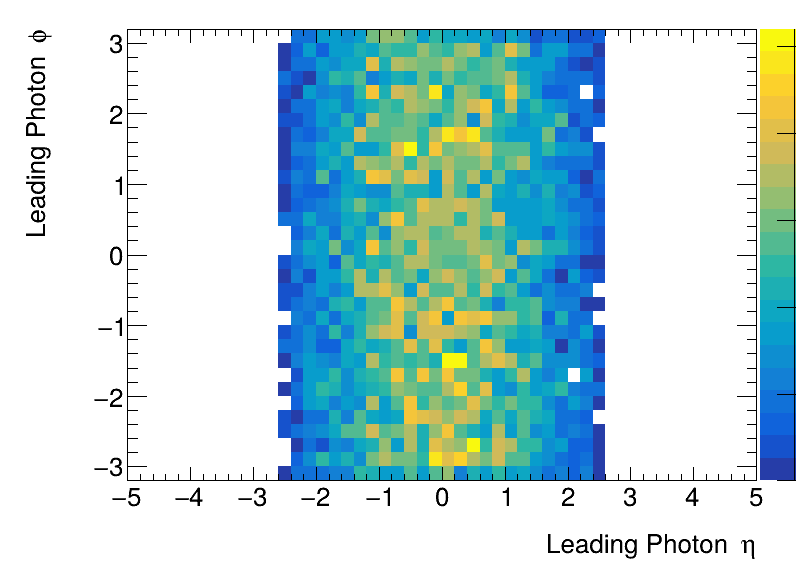

Info in <TCanvas::Print>: png file non_dark_plots/eta_vs_phi_rdf.png has been created


In [3]:
# Book the 2D histogram action.
# The histogram is filled from the columns "eta_max_pt" and "phi_max_pt".
hist_model = ROOT.RDF.TH2DModel("hist_eta_phi", "Eta vs Phi;Leading Photon #eta;Leading Photon #phi", 50, -5, 5, 32, -3.2, 3.2)
hist_eta_phi = df_final.Histo2D(hist_model, "eta_max_pt", "phi_max_pt")

# --- Drawing ---
c = ROOT.TCanvas("c", "Eta vs Phi of Highest pT Photon", 800, 600)
hist_eta_phi.SetStats(0)
hist_eta_phi.Draw("COLZ")
c.SaveAs("non_dark_plots/eta_vs_phi_rdf.png")

# Display the image in the notebook
Image(filename='non_dark_plots/eta_vs_phi_rdf.png')

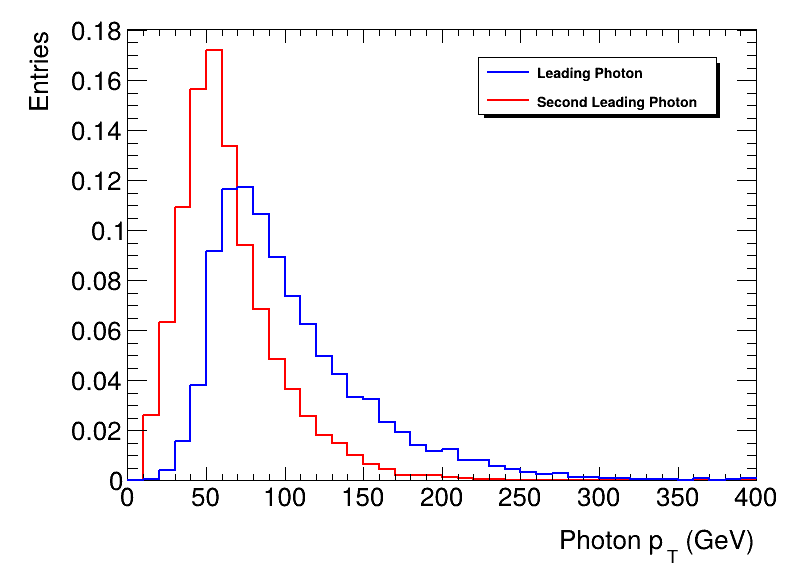

Info in <TCanvas::Print>: png file non_dark_plots/leading_photon_pt.png has been created


In [4]:
leading_color = 4
second_leading_color = 2
# Book the 1D histogram action for pt_max_pt
hist_model_pt = ROOT.RDF.TH1DModel("hist_pt", "pT of Highest pT Photon;Photon p_{T} (GeV);Entries", 40, 0, 400)
hist_pt = df_final.Histo1D(hist_model_pt, "pt_max_pt")
hist_pt.SetLineColor(leading_color)

# Book the 1D histogram action for pt_second_max_pt
hist_model_pt_second = ROOT.RDF.TH1DModel("hist_pt_second", "pT of Second Leading Photon;Photon p_{T} (GeV);Entries", 40, 0, 400)
hist_pt_second = df_final.Histo1D(hist_model_pt_second, "pt_second_max_pt")
hist_pt_second.SetLineColor(second_leading_color)

# Create a clone of the histogram to modify it
hist_with_overflow = hist_pt.Clone("hist_with_overflow")

# Add the overflow content to the last bin
overflow_bin_content = hist_with_overflow.GetBinContent(hist_with_overflow.GetNbinsX() + 1)
last_bin_content = hist_with_overflow.GetBinContent(hist_with_overflow.GetNbinsX())
hist_with_overflow.SetBinContent(hist_with_overflow.GetNbinsX(), last_bin_content + overflow_bin_content)

# Trigger the event loop and draw the histogram
c_pt = ROOT.TCanvas("c_pt", "pT of Highest pT Photon", 800, 600)
hist_with_overflow.SetStats(0)
hist_pt_second.DrawNormalized()
hist_with_overflow.DrawNormalized("SAME")
legend = ROOT.TLegend(0.6, 0.8, 0.9, 0.9)
legend.AddEntry("hist_with_overflow", "Leading Photon", "l") #FIXME Broken
legend.AddEntry("hist_pt_second", "Second Leading Photon", "l")# FIxme broken
legend.Draw()
c_pt.SaveAs("non_dark_plots/leading_photon_pt.png")

# Display the image in the notebook
Image(filename='non_dark_plots/leading_photon_pt.png')

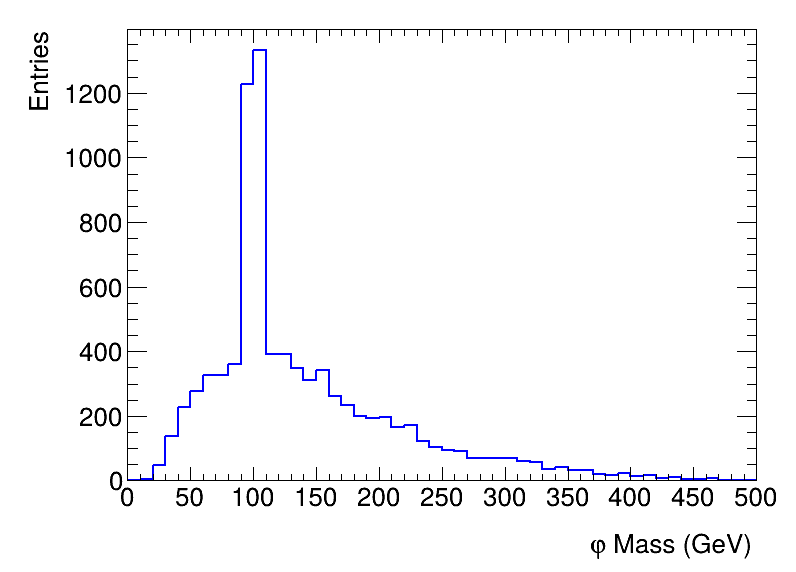

Info in <TCanvas::Print>: png file non_dark_plots/non_dark_reconstructed_phi_mass.png has been created


: 

In [ ]:
# Book the 1D histogram action for the mass of the combined 4-vector
hist_model_mass = ROOT.RDF.TH1DModel("hist_mass", "Mass of Combined Leading Photons;#varphi Mass (GeV);Entries", 50, 0, 500)
hist_mass = df_final.Histo1D(hist_model_mass, "mass_combined")

# Trigger the event loop and draw the histogram
c_mass = ROOT.TCanvas("c_mass", "Reconstructed #varphi Mass", 800, 600)
hist_mass.SetLineColor(4)
hist_mass.SetStats(0)
hist_mass.Draw()
c_mass.SaveAs("non_dark_plots/non_dark_reconstructed_phi_mass.png")

# Display the image in the notebook
Image(filename='non_dark_plots/non_dark_reconstructed_phi_mass.png')

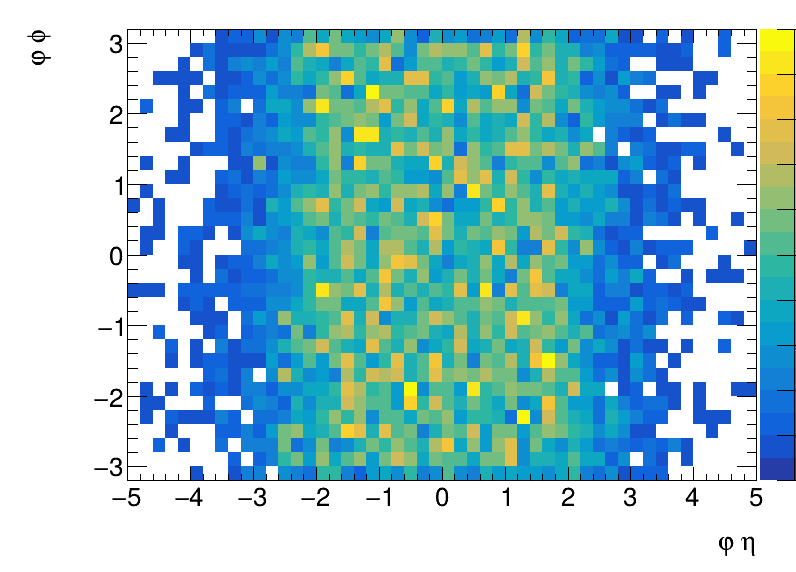

Info in <TCanvas::Print>: png file non_dark_plots/phi_eta_vs_phi_rdf.png has been created


In [ ]:
# Book the 2D histogram action.
# The histogram is filled from the columns "eta_combined" and "phi_combined".
hist_model = ROOT.RDF.TH2DModel("hist_eta_phi", "Eta vs Phi;#varphi #eta;#varphi #phi", 50, -5, 5, 32, -3.2, 3.2)
hist_eta_phi = df_final.Histo2D(hist_model, "eta_combined", "phi_combined")

# --- Drawing ---
c = ROOT.TCanvas("c", "Eta vs Phi of #varphi", 800, 600)
hist_eta_phi.SetStats(0)
hist_eta_phi.Draw("COLZ")
c.SaveAs("non_dark_plots/phi_eta_vs_phi_rdf.png")

# Display the image in the notebook
Image(filename='non_dark_plots/phi_eta_vs_phi_rdf.png')

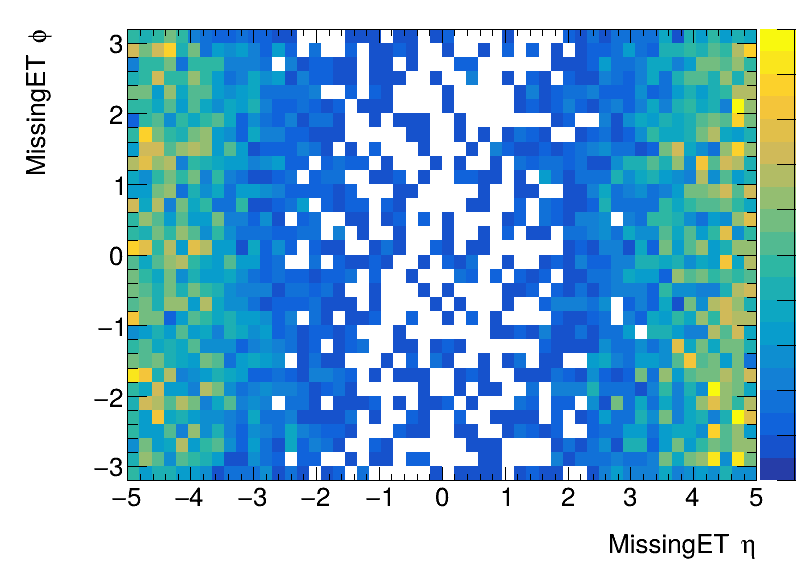

Info in <TCanvas::Print>: png file non_dark_plots/missing_et_eta_vs_phi.png has been created


In [3]:
# Book the 2D histogram action for missing ET
hist_model_met = ROOT.RDF.TH2DModel("hist_met_eta_phi", "Missing ET Eta vs Phi;MissingET #eta;MissingET #phi", 52, -5, 5, 32, -3.2, 3.2)
hist_met_eta_phi = df.Filter("MissingET_size > 0", "Events with Missing ET") \
                     .Histo2D(hist_model_met, "MissingET.Eta", "MissingET.Phi")

# --- Drawing ---
c_met = ROOT.TCanvas("c_met", "Missing ET Eta vs Phi", 800, 600)
hist_met_eta_phi.SetStats(0)
hist_met_eta_phi.Draw("COLZ")
c_met.SaveAs("non_dark_plots/missing_et_eta_vs_phi.png")

# Display the image in the notebook
Image(filename='non_dark_plots/missing_et_eta_vs_phi.png')

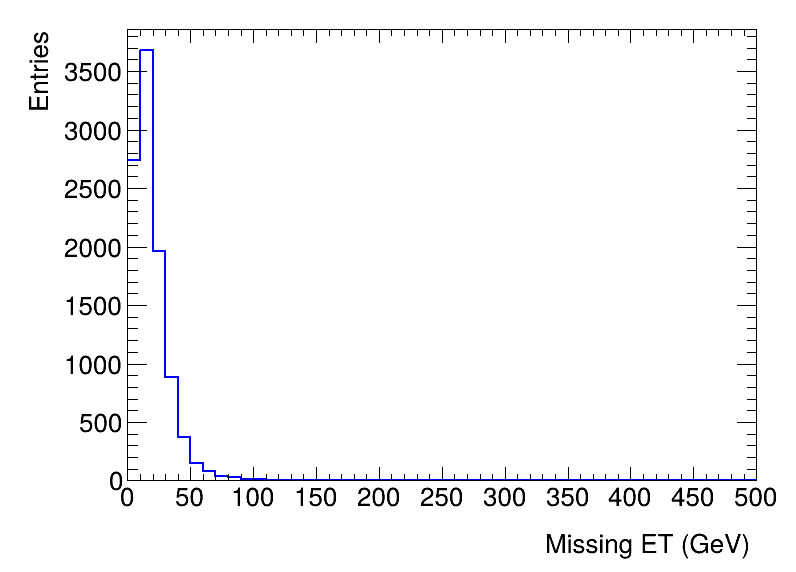

Info in <TCanvas::Print>: png file non_dark_plots/missing_et_pt.png has been created


In [4]:
# Book the 1D histogram action for missingET.MET
hist_model_met_pt = ROOT.RDF.TH1DModel("hist_met_pt", "Missing ET;Missing ET (GeV);Entries", 50, 0, 500)
hist_met_pt = df.Filter("MissingET_size > 0", "Events with Missing ET") \
                .Histo1D(hist_model_met_pt, "MissingET.MET")
hist_met_pt.SetLineColor(4)

# Create a clone of the histogram to modify it  
hist_met_with_overflow = hist_met_pt.Clone("hist_met_with_overflow")

# Add the overflow content to the last bin
overflow_bin_content_met = hist_met_with_overflow.GetBinContent(hist_met_with_overflow.GetNbinsX() + 1)
last_bin_content_met = hist_met_with_overflow.GetBinContent(hist_met_with_overflow.GetNbinsX())
hist_met_with_overflow.SetBinContent(hist_met_with_overflow.GetNbinsX(), last_bin_content_met + overflow_bin_content_met)

# Trigger the event loop and draw the histogram
c_met_pt = ROOT.TCanvas("c_met_pt", "Missing ET", 800, 600)
hist_met_with_overflow.SetStats(0)
hist_met_with_overflow.Draw()
c_met_pt.SaveAs("non_dark_plots/missing_et_pt.png")

# Display the image in the notebook
Image(filename='non_dark_plots/missing_et_pt.png')

In [4]:
# Create the RDataFrame
df_init = ROOT.RDataFrame("Delphes", fdir)

# Set the time cut for selecting displaced candidates (in nanoseconds)
TIME_CUT_NS = 12.**(-9)

# Filter for events with at least one photon
df_photons = df_init.Filter("Photon_size > 0", "Events with at least one photon")

# Filter for events containing at least one late-arriving photon
df_late = df_photons.Filter(f"ROOT::VecOps::Max(Photon.T) > {TIME_CUT_NS}", "Select events with late photons")

# In these events, find the index of the LATEST arriving photon
df_final = df_late.Define("idx_late_photon", "ROOT::VecOps::ArgMax(Photon.T)") \
                  .Define("pt_late_photon", "Photon.PT[idx_late_photon]") \
                  .Define("eta_late_photon", "Photon.Eta[idx_late_photon]") \
                  .Define("phi_late_photon", "Photon.Phi[idx_late_photon]") \
                  .Define("t_late_photon", "Photon.T[idx_late_photon]") \
                  .Define("e_late_photon", "Photon.E[idx_late_photon]") \
                  .Define("theta_late_photon", "2 * TMath::ATan(TMath::Exp(-eta_late_photon))") \
                  .Define("e_theta_late_photon", "TMath::ASin(pt_late_photon / e_late_photon)") \
                  .Define("photon_t", "Photon.T * 1e9")


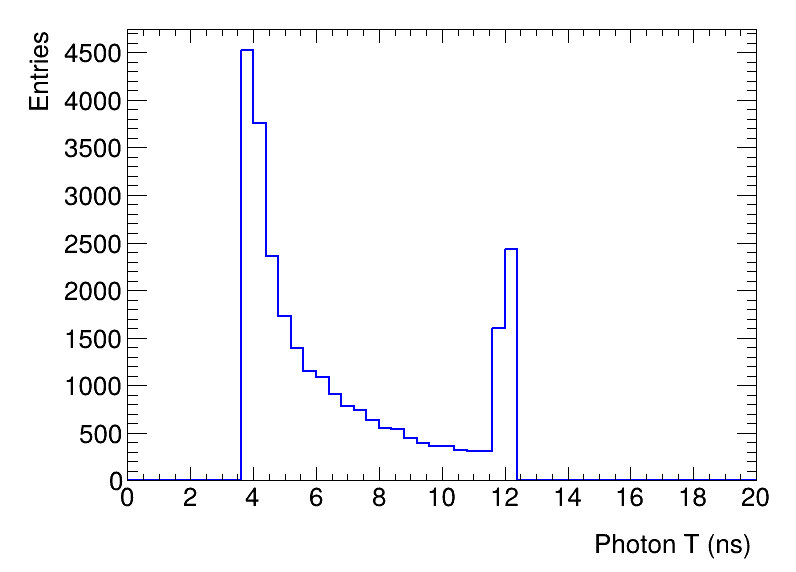

Info in <TCanvas::Print>: png file non_dark_plots/photon_t.png has been created


In [5]:
# Book the 1D histogram action for Photon.T
hist_model_photon_t = ROOT.RDF.TH1DModel("hist_photon_t", "Photon T;Photon T (ns);Entries", 50, 0, 20)
hist_photon_t = df_final.Histo1D(hist_model_photon_t, "photon_t")
hist_photon_t.SetLineColor(4)

# Create a clone of the histogram to modify it
hist_photon_t_with_overflow = hist_photon_t.Clone("hist_photon_t_with_overflow")

# Add the overflow content to the last bin
overflow_bin_content_t = hist_photon_t_with_overflow.GetBinContent(hist_photon_t_with_overflow.GetNbinsX() + 1)
last_bin_content_t = hist_photon_t_with_overflow.GetBinContent(hist_photon_t_with_overflow.GetNbinsX())
hist_photon_t_with_overflow.SetBinContent(hist_photon_t_with_overflow.GetNbinsX(), last_bin_content_t + overflow_bin_content_t)

# Trigger the event loop and draw the histogram
c_photon_t = ROOT.TCanvas("c_photon_t", "Photon T", 800, 600)
hist_photon_t_with_overflow.SetStats(0)
hist_photon_t_with_overflow.Draw()
c_photon_t.SaveAs(f"{save_folder}/photon_t.png")

# Display the image in the notebook
Image(filename=f"{save_folder}/photon_t.png")

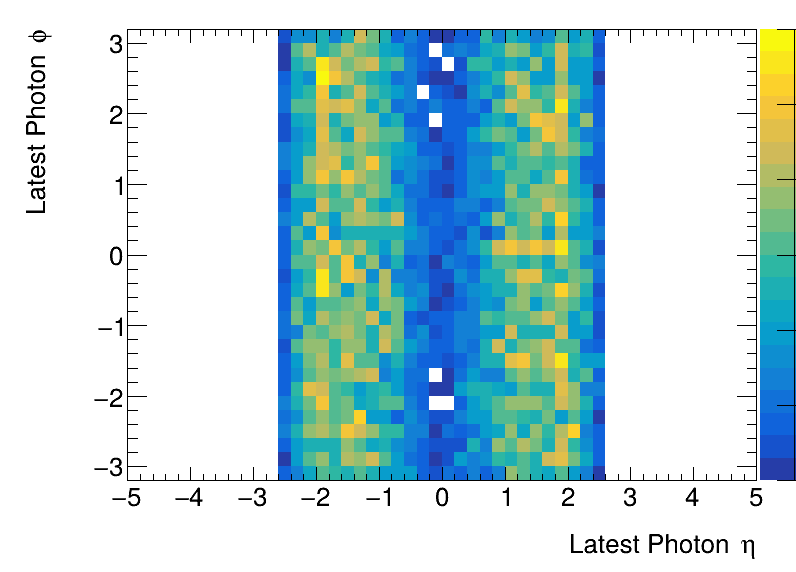

Info in <TCanvas::Print>: png file non_dark_plots/eta_vs_phi_late.png has been created


In [6]:
# Book the 2D histogram action.
# The histogram is filled from the columns "eta_max_pt" and "phi_max_pt".
hist_model = ROOT.RDF.TH2DModel("hist_eta_phi", "Eta vs Phi;Latest Photon #eta;Latest Photon #phi", 50, -5, 5, 32, -3.2, 3.2)
hist_eta_phi = df_final.Histo2D(hist_model, "eta_late_photon", "phi_late_photon")

# --- Drawing ---
c = ROOT.TCanvas("c", "Eta vs Phi of Latest Arrival Photon", 800, 600)
hist_eta_phi.SetStats(0)
hist_eta_phi.Draw("COLZ")
c.SaveAs(f"{save_folder}/eta_vs_phi_late.png")

# Display the image in the notebook
Image(filename=f"{save_folder}/eta_vs_phi_late.png")

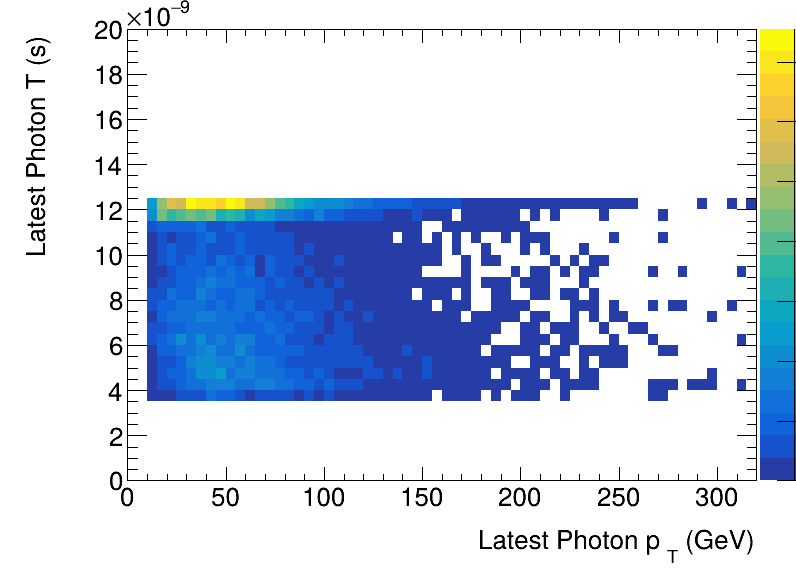

Info in <TCanvas::Print>: png file non_dark_plots/pt_vs_t_late.png has been created


In [5]:
# Book the 2D histogram action.
# The histogram is filled from the columns "pt_late_photon" and "t_late_photon".
hist_model = ROOT.RDF.TH2DModel("hist_pt_t", "p_{T} vs T;Latest Photon p_{T} (GeV);Latest Photon T (s)", 64, 0, 320, 40, 0, 20*10**-9)
hist_pt_t = df_final.Histo2D(hist_model, "pt_late_photon", "t_late_photon")

# --- Drawing ---
c = ROOT.TCanvas("c", "pT vs T of Latest Arrival Photon", 800, 600)
hist_pt_t.SetStats(0)
hist_pt_t.Draw("COLZ")
c.SaveAs(f"{save_folder}/pt_vs_t_late.png")

# Display the image in the notebook
Image(filename=f"{save_folder}/pt_vs_t_late.png")